## ML project 2

### Notes

- train model for each expert
- 0.5 'missing gender' somehing else than male/ female
- model ohne metadata wie age gender etc, just the coughs
- person coughs --> want to tell wether wet or dry
- dont use other expert information

Features:

- Columns C-BQ: Computed features in the time and frequency domain
- Column BR: The expert that reviwed the cough
- Columns BS-BV: Metadata features provided by users
    - Some values were not provided by users and were set to average values for each feature
- The 'SNR' feature exists for non-segmented coughs but not segmented coughs

MISC:

- Deal with missing metadata appropriately

- Perform exploratory data analysis and feature engineering (ex. examine theeffects of normalizing features, recursive feature elimination)

- Make sure that data from a single subject does not end up in both thetraining and validation groups

Cross validation:

- Compare the success of different classifiers, very carefully performing afair model comparison (i.e. relying on validation scores using leave-n-subjects-out cross-validation).

Model Comparison:


- Compare classification success on segmented and non-segmented coughrecordings (all pre-processing will be done by the lab)
- Tune the model hyperparameters appropriately

- Assess the importance of different features to the classification result by analyzing the weights of the classifier or SHAP values.


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import IPython.display
import matplotlib.pyplot as plt
import importlib
import src.utils
from src.utils.preprocessing import import_data, standardize, dummy_code, oversample, remove_correlated_features
from src.utils.model_helpers import roc_w_cross_val, AUC_all_models, homemade_all_models
from src.utils.model.train import cross_validation, cross_validation_iter, train_test_split

In [19]:
# Preprocessing
from imblearn.over_sampling import SMOTE
# ML models
from sklearn.metrics import plot_roc_curve, auc, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [38]:
# to reload modules
importlib.reload(src.utils.preprocessing)
importlib.reload(src.utils.model.train)
importlib.reload(src.utils.model_helpers)


<module 'src.utils.model_helpers' from '/home/mogan/Dropbox/Semester_1_EPFL/ML_Project/Project2/cs-433-project-2-cough_classifier/src/utils/model_helpers.py'>

In [4]:
# dir(src.utils.preprocessing)

In [5]:
DATA_PATH = '../../data'

## Load Data

In [6]:
# Load data
# Labels: # 1 - Wet Cough # 0 - Dry Cough
coarse_data, coarse_labels = import_data(DATA_PATH, segmentation_type = 'coarse', is_user_features=True)
fine_data, fine_labels = import_data(DATA_PATH, segmentation_type = 'fine', is_user_features=True)
no_data, no_labels = import_data(DATA_PATH, segmentation_type = 'no', is_user_features=True)

# For later processing rename the index
no_data.index = no_data.index.rename('subject')
#display(coarse_data.head(2), fine_data.head(2), no_data.head(2))
#display(coarse_labels.head(2), fine_labels.head(2), no_labels.head(2))

In [7]:
# if no preprocessing is desired
X_coarse = coarse_data
X_fine = fine_data
X_no = no_data

## EDA

In [ ]:
# Xavi?

## Data Preprocessing

### Normalisation

In [8]:
# For case where is_user_features=True
X_coarse = standardize(X_coarse, 0,-3)
X_fine = standardize(X_fine, 0,-3)
X_no = standardize(X_no, 0,-3)

### Inspect Missing Data

### Dummy code categorical features

In [7]:
X_coarse = dummy_code(X_coarse, columns = ['Gender', 'Resp_Condition', 'Symptoms'])
X_fine = dummy_code(X_fine, columns = ['Gender', 'Resp_Condition', 'Symptoms'])
X_no = dummy_code(X_no, columns = ['Gender', 'Resp_Condition', 'Symptoms'])

### Train and Test data

In [23]:
#no_data_X_tr, no_labels_y_tr, no_data_X_te,  no_labels_y_te = train_test_split(X_no, no_labels)
#coarse_data_X_tr, coarse_labels_y_tr, coarse_data_X_te, coarse_labels_y_te = train_test_split(X_coarse, coarse_labels)
#fine_data_X_tr, fine_labels_y_tr, fine_data_X_te, fine_labels_y_te = train_test_split(X_fine, fine_labels)

### Class imbalance

In [89]:
print("Proportion of positive labels:", "\n", np.round(no_labels['Label'].sum() / no_labels['Label'].shape[0],4), 
                                              np.round(coarse_labels['Label'].sum() / coarse_labels['Label'].shape[0],4),
      np.round(fine_labels['Label'].sum() / fine_labels['Label'].shape[0],4))

Proportion of positive labels: 
 0.5 0.5 0.5


#### Has to be applied after splitting train and test set, since it annulates multilevel indexes

In [163]:
# Do something about it: SMOTE
X_coarse, coarse_labels = oversample(X_coarse, coarse_labels)
X_fine, fine_labels = oversample(X_fine, fine_labels)
X_no, no_labels = oversample(X_no, no_labels)

## Feature Engineering

### Feature Selection

#### Drop correlated features

In [14]:
# Drop features with a Pearson correlation > 0.9 to prevent multicollinearity
X_no = remove_correlated_features(X_no, 0.90)
X_coarse = remove_correlated_features(X_coarse, 0.90)
X_fine = remove_correlated_features(X_fine, 0.90)

### Find interesting features

In [68]:
X_no.shape[1]

50

>2 0.619 (0.050)
>3 0.642 (0.050)
>4 0.636 (0.051)
>5 0.634 (0.048)
>6 0.632 (0.047)
>7 0.628 (0.047)
>8 0.632 (0.048)
>9 0.632 (0.047)
>10 0.635 (0.047)
>11 0.639 (0.047)
>12 0.645 (0.047)
>13 0.646 (0.048)
>14 0.643 (0.048)
>15 0.641 (0.049)
>16 0.636 (0.049)
>17 0.633 (0.047)
>18 0.632 (0.049)
>19 0.631 (0.050)
>20 0.628 (0.048)
>21 0.628 (0.047)
>22 0.627 (0.047)
>23 0.627 (0.046)
>24 0.627 (0.047)
>25 0.626 (0.048)
>26 0.628 (0.048)
>27 0.628 (0.048)
>28 0.629 (0.049)
>29 0.632 (0.050)
>30 0.631 (0.050)
>31 0.633 (0.049)
>32 0.632 (0.048)
>33 0.634 (0.047)
>34 0.635 (0.047)
>35 0.635 (0.047)
>36 0.635 (0.047)
>37 0.634 (0.047)
>38 0.634 (0.048)
>39 0.635 (0.048)
>40 0.635 (0.048)
>41 0.636 (0.048)
>42 0.636 (0.048)
>43 0.636 (0.049)
>44 0.636 (0.049)
>45 0.635 (0.048)
>46 0.635 (0.048)
>47 0.635 (0.048)
>48 0.635 (0.048)
>49 0.635 (0.048)


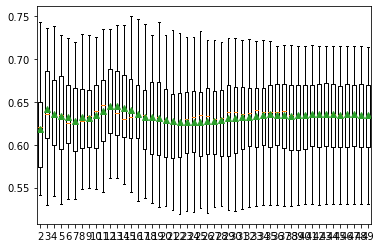

In [78]:
# Do recursive feature elimination
from sklearn.feature_selection import RFE
# explore the number of selected features for RFE
from numpy import mean
from numpy import std
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.pipeline import Pipeline
from matplotlib import pyplot

# get a list of models to evaluate
def get_models(X):
    models = dict()
    for i in range(2, X.shape[1]):
        rfe = RFE(estimator=LogisticRegression(), n_features_to_select=i)
        model = LogisticRegression()
        models[str(i)] = Pipeline(steps=[('s',rfe),('m',model)])
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return scores
 

def RFE_(X, y):
    # get the models to evaluate
    models = get_models(X)
    # evaluate the models and store results
    results, names = list(), list()
    for name, model in models.items():
        scores = evaluate_model(model, X, y.Label)
        results.append(scores)
        names.append(name)
        print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
        # write results in pandas df 
        
    
    # plot model performance for comparison
    pyplot.boxplot(results, labels=names, showmeans=True)
    pyplot.show()
    
    return results

In [79]:
results

[array([0.55190017, 0.6817924 , 0.55965211, 0.57175269, 0.6097561 ,
        0.64965022, 0.74305162, 0.57874835, 0.68878805, 0.61837591,
        0.62431462, 0.62771791, 0.55587067, 0.54755152, 0.63698242,
        0.65475515, 0.69219134, 0.61070146, 0.59519758, 0.60198246,
        0.55681603, 0.649083  , 0.64927207, 0.67101531, 0.57024012,
        0.6617508 , 0.54150123, 0.62885234, 0.64057478, 0.59740755]),
 array([0.57950463, 0.68992248, 0.62412554, 0.60559652, 0.62280204,
        0.68254869, 0.73681225, 0.61353753, 0.68689733, 0.6361037 ,
        0.70372471, 0.68859898, 0.53015693, 0.5757232 , 0.65456608,
        0.64303271, 0.69748535, 0.64586878, 0.59444129, 0.62295082,
        0.60559652, 0.68651919, 0.66420874, 0.71072036, 0.59406315,
        0.61769711, 0.55454717, 0.6350917 , 0.71790509, 0.63495997]),
 array([0.56778219, 0.67498582, 0.64700321, 0.58328607, 0.6237474 ,
        0.67612025, 0.73889204, 0.61013424, 0.69464927, 0.60503241,
        0.68689733, 0.67876725, 0.54490452, 

In [76]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_weighted'])

###  Polynomial Feature Expansion

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

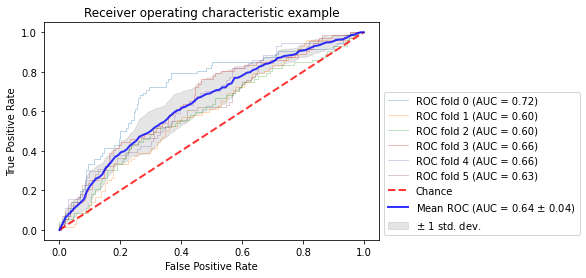

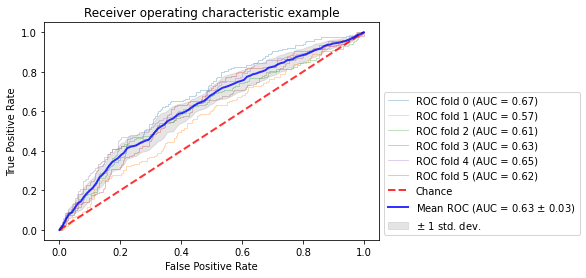

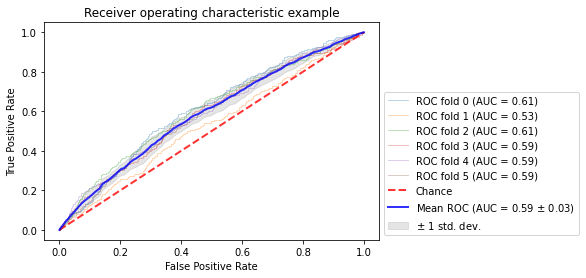

0.587481350259372

In [62]:
# Inspect effects for log regression
roc_w_cross_val(X_no, no_labels.Label, LogisticRegression())
roc_w_cross_val(X_coarse, coarse_labels.Label, LogisticRegression())
roc_w_cross_val(X_fine, fine_labels.Label, LogisticRegression())

## Methoden

In [ ]:
#coarse_results = AUC_all_models(X_coarse, coarse_labels.Label)
#fine_results = AUC_all_models(X_fine, fine_labels.Label)
no_results = AUC_all_models(X_no, no_labels.Label)


#### Inspect results

In [65]:
pd.concat([coarse_results, fine_results['AUC (mean)'], no_results['AUC (mean)']], axis=1, sort=False)

,Models,AUC (mean),AUC (mean),AUC (mean)
0,LogisticRegression,0.622908,0.585994,0.641645
1,SVM,0.546796,0.550846,0.596320
2,LDA,0.623598,0.586567,0.641259
3,KNN,0.560557,0.568451,0.574055
4,GaussianNB,0.595900,0.570045,0.624681
5,DecisionTree,0.518979,0.525022,0.512041
6,RandomForest,0.604542,0.601413,0.604854
7,GradientBoosting,0.611636,0.608871,0.608470


### Logistic regression

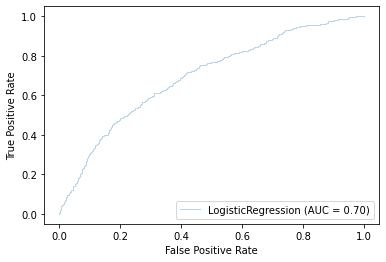

In [60]:
logistic = LogisticRegression()
logistic.fit(X_no, no_labels.Label)

fig, ax = plt.subplots()
plot_roc_curve(logistic, X_no, no_labels,
                         alpha=0.3, lw=1, ax=ax)

plt.show()

In [55]:
cross_validation(X_no, no_labels.Label, 5, LogisticRegression(), metric=roc_auc_score)

0.5241780185800045

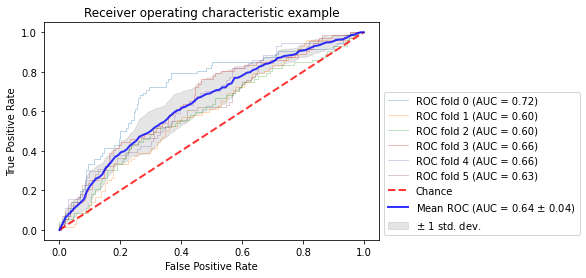

0.6425410863986764

In [59]:
roc_w_cross_val(X_no, no_labels.Label, LogisticRegression())

In [40]:
homemade_all_models(X_no, no_labels.Label, 5) #AUC 62

,models,AUC (mean)
0,LogisticRegression,0.524648
1,SVM,0.500000
2,LDA,0.527867
3,KNN,0.526875
4,GaussianNB,0.561609
5,DecisionTree,0.516939
6,RandomForest,0.502588
7,GradientBoosting,0.511983


### k Nearest Neighbour

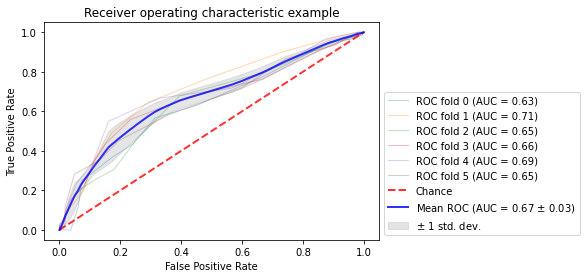

In [49]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, KNeighborsClassifier(n_neighbors=16))

### Gaussian Naive Bayes

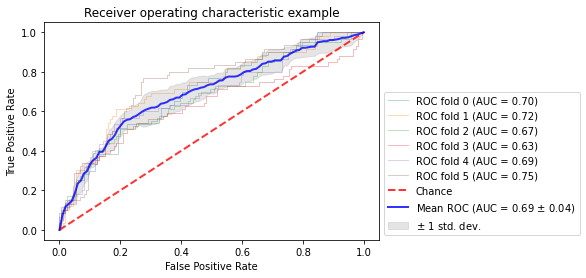

In [50]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, GaussianNB())

### Decision Tree

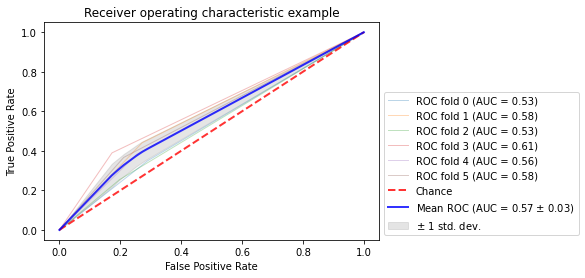

In [73]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, DecisionTreeClassifier(random_state=0))

### RandomForest

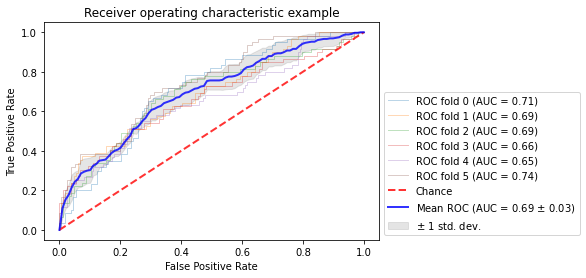

In [78]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, RandomForestClassifier(max_depth=7, random_state=0))

### eXtreme Gradient Boosting

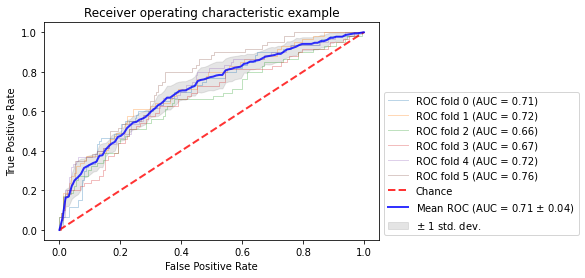

In [79]:
roc_w_cross_val(no_data_X_tr, no_labels_y_tr, GradientBoostingClassifier(random_state=0))